In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# Load CSVs
findings_path = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train.csv"
images_path =r"C:\Users\anude\Downloads\project\ProstateX-Images-Train.csv"

df_findings = pd.read_csv(findings_path)
df_images = pd.read_csv(images_path)

# --- BASIC STATS ---
print(f"Number of Patients: {df_findings['ProxID'].nunique()}")
print(f"Total Findings: {len(df_findings)}")


Number of Patients: 204
Total Findings: 330


In [5]:
# Check the unique zones
print("Available Zones:", df_findings['zone'].unique())

# Step 1: Calculate lesion zone distribution
zone_counts = df_findings['zone'].value_counts()
total_lesions = zone_counts.sum()

zone_percentages = (zone_counts / total_lesions) * 100

print("\nLesion Zone Distribution (%):")
for zone, pct in zone_percentages.items():
    print(f"{zone}: {pct:.1f}%")

Available Zones: ['PZ' 'AS' 'TZ' 'SV']

Lesion Zone Distribution (%):
PZ: 57.9%
TZ: 24.8%
AS: 16.7%
SV: 0.6%


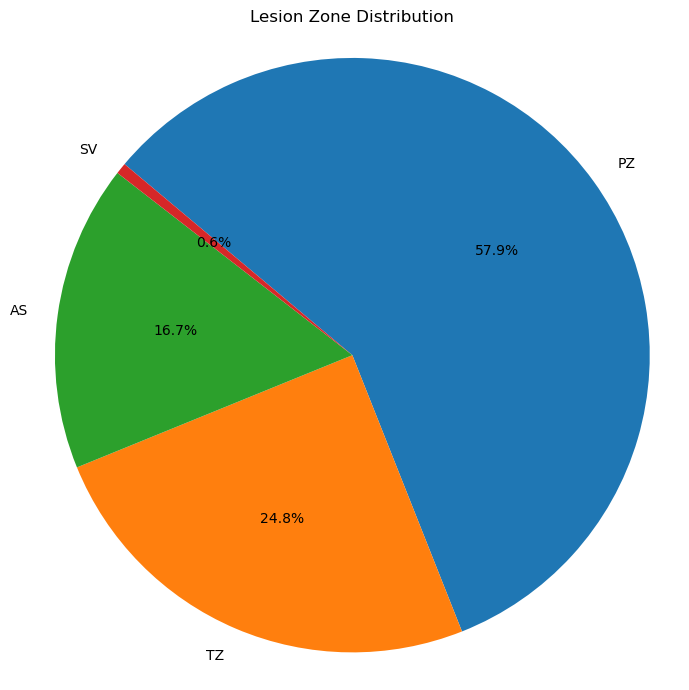

In [7]:
# Pie chart for zones
plt.figure(figsize=(7,7))
plt.pie(zone_percentages, labels=zone_percentages.index, autopct='%1.1f%%', startangle=140, counterclock=False)
plt.title('Lesion Zone Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [15]:
# Lesions per patient
lesions_per_patient = df_findings.groupby('ProxID').size()
patient_lesion_counts = Counter(lesions_per_patient)

total_patients = len(lesions_per_patient)

patients_with_1 = patient_lesion_counts.get(1, 0) / total_patients * 100
patients_with_2 = patient_lesion_counts.get(2, 0) / total_patients * 100
patients_with_3 = patient_lesion_counts.get(3, 0) / total_patients * 100

print("\nLesions per Patient Distribution (%):")
print(f"Single lesion: {patients_with_1:.1f}%")
print(f"Two lesions:   {patients_with_2:.1f}%")
print(f"Three lesions: {patients_with_3:.1f}%")


Lesions per Patient Distribution (%):
Single lesion: 54.4%
Two lesions:   31.4%
Three lesions: 12.7%


In [9]:

# --- MISSING VALUES ---
print("\nMissing Values in Findings:")
print(df_findings.isnull().sum())

print("\nMissing Values in Images:")
print(df_images.isnull().sum())



Missing Values in Findings:
ProxID     0
fid        0
pos        0
zone       0
ClinSig    0
dtype: int64

Missing Values in Images:
ProxID                     0
Name                       0
fid                        0
pos                        0
WorldMatrix                0
ijk                        0
TopLevel                3356
SpacingBetweenSlices       0
VoxelSpacing               0
Dim                        0
DCMSerDescr                0
DCMSerNum                  0
dtype: int64



ClinSig Distribution:
ClinSig
False    254
True      76
Name: count, dtype: int64


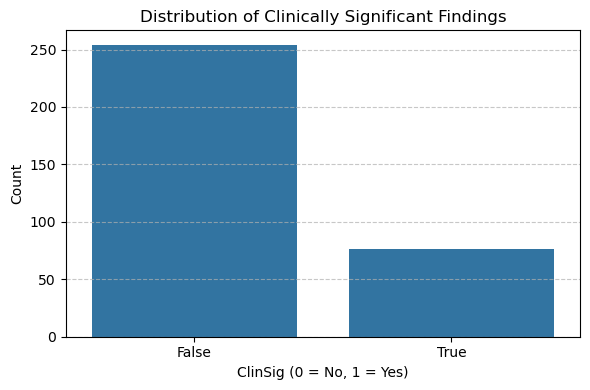

In [11]:

# --- CLINSIG DISTRIBUTION ---
clinsig_counts = df_findings['ClinSig'].value_counts(dropna=False)
print("\nClinSig Distribution:")
print(clinsig_counts)

plt.figure(figsize=(6, 4))
sns.countplot(data=df_findings, x='ClinSig')
plt.title('Distribution of Clinically Significant Findings')
plt.xlabel('ClinSig (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



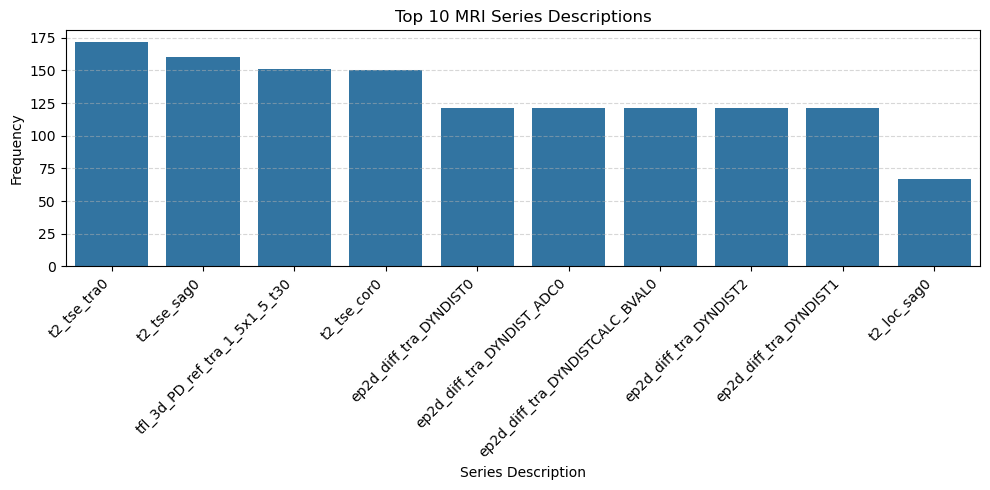

In [13]:
# --- TOP SERIES DESCRIPTIONS ---
plt.figure(figsize=(10, 5))
sns.barplot(x=top_series_names.index, y=top_series_names.values)
plt.title('Top 10 MRI Series Descriptions')
plt.xlabel('Series Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

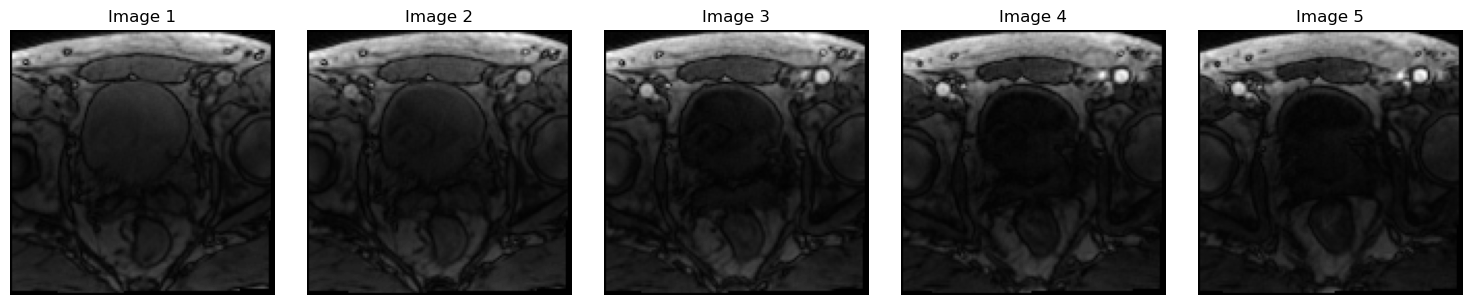

In [17]:
import pydicom
import matplotlib.pyplot as plt
import os

# Directory containing the extracted DICOM files
dicom_dir = r"C:\Users\anude\Downloads\project\ProstateX-0000"

# List to store DICOM file paths
dicom_files = []
for root, dirs, files in os.walk(dicom_dir):
    for file in files:
        if file.lower().endswith(".dcm"):
            dicom_files.append(os.path.join(root, file))

# Function to display multiple DICOM images
def display_dicom_images(dicom_files, num_images=10, columns=5):
    num_images = min(num_images, len(dicom_files))
    rows = (num_images + columns - 1) // columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i in range(num_images):
        dicom = pydicom.dcmread(dicom_files[i])
        img = dicom.pixel_array  # Extract the pixel array

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 10 DICOM images
display_dicom_images(dicom_files, num_images=5)


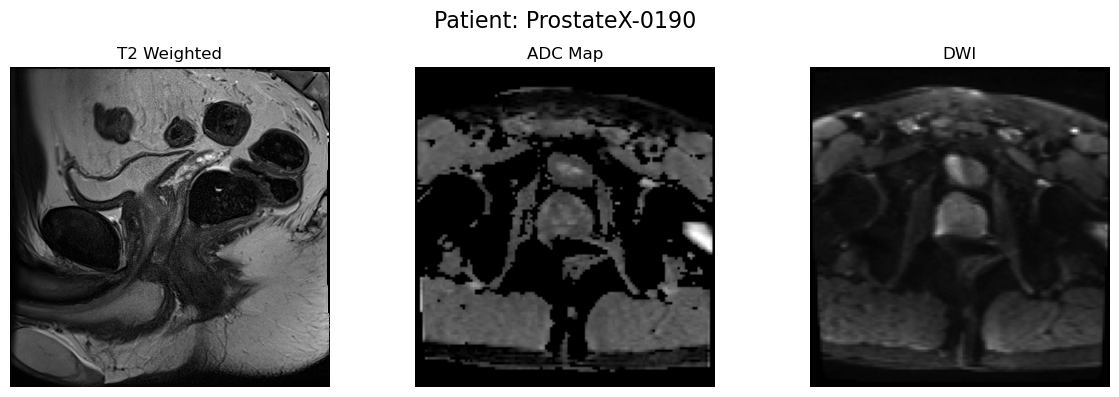

In [23]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Set your dataset root folder
DICOM_ROOT = r"C:\Users\anude\Downloads\project" 

# ==== LOAD SLICE FUNCTION ====
def load_slice(proxid, descr_list, slice_idx='middle'):
    """
    Searches for a DICOM series under a patient's folder (proxid) matching any description in descr_list.
    Returns the pixel array of the DICOM file at given slice_idx ('middle' means auto-select middle slice).
    """
    patient_path = os.path.join(DICOM_ROOT, proxid)
    for root, dirs, files in os.walk(patient_path):
        for descr in descr_list:
            if descr.lower() in root.lower():
                dcm_files = [f for f in os.listdir(root) if f.endswith(".dcm")]
                if not dcm_files:
                    print(f"No DICOM files found in {root}")
                    return None
                
                # Read and sort by InstanceNumber
                dcm_paths = [os.path.join(root, f) for f in dcm_files]
                dicoms = []
                for path in dcm_paths:
                    try:
                        dicoms.append(pydicom.dcmread(path))
                    except Exception as e:
                        print(f"Error reading {path}: {e}")
                
                if not dicoms:
                    print(f"Failed to read DICOMs in {root}")
                    return None

                dicoms.sort(key=lambda x: int(x.InstanceNumber))

                if slice_idx == 'middle':
                    slice_idx = len(dicoms) // 2

                if 0 <= slice_idx < len(dicoms):
                    return dicoms[slice_idx].pixel_array
                else:
                    print(f"Slice index {slice_idx} out of range for {root}")
                    return None
    print(f"No matching folder found for {proxid} with keywords {descr_list}")
    return None

# ==== PLOT FUNCTION ====
def plot_patient_mri(proxid):
    t2_img = load_slice(proxid, ['t2', 't2w', 't2-weighted'])
    adc_img = load_slice(proxid, ['adc'])
    dwi_img = load_slice(proxid, ["dwi", "diffusion", "ep2d_diff", "ep2d"])

    if t2_img is None or adc_img is None or dwi_img is None:
        print(f"Cannot plot for {proxid}: missing one or more modalities.")
        return

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(t2_img, cmap='gray')
    axes[0].set_title('T2 Weighted')
    axes[0].axis('off')

    axes[1].imshow(adc_img, cmap='gray')
    axes[1].set_title('ADC Map')
    axes[1].axis('off')

    axes[2].imshow(dwi_img, cmap='gray')
    axes[2].set_title('DWI')
    axes[2].axis('off')

    plt.suptitle(f'Patient: {proxid}', fontsize=16)
    plt.tight_layout()
    plt.show()

patient_id = 'ProstateX-0190'   
plot_patient_mri(patient_id)
